In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

TRAIN_SPLIT = 0.8
FEAT_LENGTH = 30
FEAT_COLS = ['Open', 'Low', 'High', 'Close']
TICKERS = ['TSLA', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMD', 'ISP.MI', 'LMT']


def time_series(df: pd.DataFrame,
                col: str,
                name: str) -> pd.DataFrame:
    '''
    Form the lagged columns for this feature
    '''
    return df.assign(**{
        f'{name}_t-{lag}': col.shift(lag)
        for lag in range(0, FEAT_LENGTH)
    })


def get_lagged_returns(df: pd.DataFrame) -> pd.DataFrame:
    '''
    For each of the feature cols, find the returns and then form the lagged
    time-series as new columns
    '''
    for col in FEAT_COLS:
        return_col = df[col]/df[col].shift(1)-1
        df = time_series(df, return_col, f'feat_{col}_ret')
        
    return df


def get_classification(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Get the classifications for the LSTM network, which are as follows:
        0 = The 20 period SMA is below the low of the day
        1 = The 20 period SMA is between the low and high of the day
        2 = The 20 period SMA is above the high of the day
    '''
    
    df['ma'] = df['Close'].rolling(20).mean()
    
    conditions = [
        df['ma'] <= df['Low'],
        (df['ma'] < df['High']) & (df['ma'] > df['Low']),
        df['ma'] >= df['High'],
    ]
    
    df['classification'] = np.select(
        condlist = conditions,
        choicelist = [0, 1, 2],
    )
    
    return df
    

def reshape_x(x: np.array) -> np.array:
    
    # Calculate the number of features we have in the nn (assumes all features
    # are of the same length)
    num_feats = x.shape[1]//FEAT_LENGTH
    
    # Initialise the new x array with the correct size
    x_reshaped = np.zeros((x.shape[0], FEAT_LENGTH, num_feats))
    
    # Populate this array through iteration
    for n in range(0, num_feats):
        x_reshaped[:, :, n] = x[:, n*FEAT_LENGTH:(n+1)*FEAT_LENGTH]
    
    return x_reshaped


def get_nn_data():
    '''
    For all tickers, deduce the NN features and classifications, and then save
    the outputs as four numpy arrays (x_train, y_train, x_test, y_test)
    '''
    
    dfs = []
    for ticker in TICKERS:
        df = pd.read_csv(f'netLSTM/datasets/{ticker}.csv')
        
        df = get_lagged_returns(df)
        df = get_classification(df)
        
        dfs.append(
            df
            .replace([np.inf, -np.inf], np.nan)
            .dropna()
            [[col for col in df.columns if 'feat_' in col] + ['classification']]
        )
        
    nn_values = pd.concat(dfs).values
    
    # Shuffle the values to ensure the NN does not learn an order
    np.random.shuffle(nn_values)
    
    # Split into training and test data
    split_idx = int(TRAIN_SPLIT*nn_values.shape[0])
    
    # Save the x training data
    np.save('netLSTM/x_train', reshape_x(nn_values[0:split_idx, :-1]))
    
    # Save the y training data
    np.save('netLSTM/y_train', nn_values[0:split_idx:, -1])
    
    # Save the x testing data
    np.save('netLSTM/x_test', reshape_x(nn_values[split_idx:, :-1]))
    
    # Save the y testing data
    np.save('netLSTM/y_test', nn_values[split_idx:, -1])
    
    return
    

if __name__ == '__main__':
    
    get_nn_data()

In [2]:
import torch
import NetMarket
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Supponiamo che queste siano state definite da qualche parte nel tuo codice
# dataset_train = ...
# model = BiLSTMNet(...)
model = NetMarket.LSTMNet(4)
#

# Impostazioni per la loss function e l'ottimizzatore
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#Load data
x_train = np.load("netLSTM/x_train.npy")
y_train = np.load("netLSTM/y_train.npy")
x_test = np.load("netLSTM/x_test.npy")
y_test = np.load("netLSTM/y_test.npy")

#TENSOR

x_train = torch.tensor(x_train).double()
y_train = torch.tensor(y_train).double()
x_test = torch.tensor(x_test).double()
y_test = torch.tensor(y_test).double()

#
x_train = x_train.to("cuda:0")
y_train = y_train.to("cuda:0")
x_test = x_test.to("cuda:0")
y_test = y_test.to("cuda:0")
#
model = model.double()
model = model.to("cuda:0")

In [3]:
dataset_train = TensorDataset(x_train,y_train)
data_loader_train = DataLoader(dataset_train, batch_size=124, shuffle=True)

dataset_test = TensorDataset(x_test,y_test)
data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

# Funzione per calcolare l'accuracy
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    return (predicted == y_true).sum().item()

In [4]:
epochs = 500

#Plot result
pathname = "models/test6"
os.makedirs(pathname, exist_ok=True)
results = []
list_loss_train = []
list_accuracy_train = []
list_loss_test = []
list_accuracy_test = []
# Ciclo di training
model.train()  # Imposta il modello in modalità training

for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    total_len_train = 0
    
    model.train()
    for x, y_true in data_loader_train:
        # Forward pass
        predictions = model(x)
        loss = loss_function(predictions, y_true.long())
        
        # Backward pass e ottimizzazione
        optimizer.zero_grad()  # Azzera i gradienti esistenti
        loss.backward()        # Calcola i gradienti retropropagati
        optimizer.step()       # Aggiorna i pesi della rete

        total_loss += loss.item()
        total_correct += calculate_accuracy(y_true, predictions)
        total_len_train += x.size(0)
    avg_loss_train = total_loss / len(data_loader_train)
    avg_accuracy_train = total_correct / total_len_train
    
    total_loss = 0
    total_correct = 0
    model.eval()
    total_len_test = 0
    for x, y_true in data_loader_test:
        # Forward pass
        predictions = model(x)
        loss = loss_function(predictions, y_true.long())

        total_loss += loss.item()
        total_correct += calculate_accuracy(y_true, predictions)
        total_len_test += x.size(0)
    avg_loss_test = total_loss / len(data_loader_test)
    avg_accuracy_test = total_correct / total_len_test
    model.train()
      
    result = f"Epoch [{epoch+1}/{epochs}], Loss-Train: {avg_loss_train:.4f}, Accuracy-Train: {avg_accuracy_train:.4f}, Loss-Test: {avg_loss_test:.4f}, Accuracy-Test: {avg_accuracy_test:.4f}"
    print(result)
    
    #add to list
    list_loss_train.append(avg_loss_train)
    list_accuracy_train.append(avg_accuracy_train)
    list_loss_test.append(avg_loss_test)
    list_accuracy_test.append(avg_accuracy_test)
    results.append(result)
    
#Save plot loss
display.clear_output(wait=True)
plt.plot(list_loss_train, label='Training Loss')
plt.plot(list_loss_test, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for Epoch')
plt.legend()
plt.savefig(f'{pathname}/Loss.png')
plt.clf()

#Save plot accuracy
display.clear_output(wait=True)
plt.plot(list_accuracy_train, label='Accuracy Train')
plt.plot(list_accuracy_test, label='Accuracy Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for Epoch')
plt.legend()
plt.savefig(f'{pathname}/Accuracy-test.png')
plt.clf()
    
with open(f"{pathname}/results.txt", "w") as f:
    for result in results:
        f.write(result + "\n")



<Figure size 640x480 with 0 Axes>

In [5]:
torch.save(model, f'{pathname}/model.pth')

In [6]:
#model = torch.load("models/BEST/model.pth")

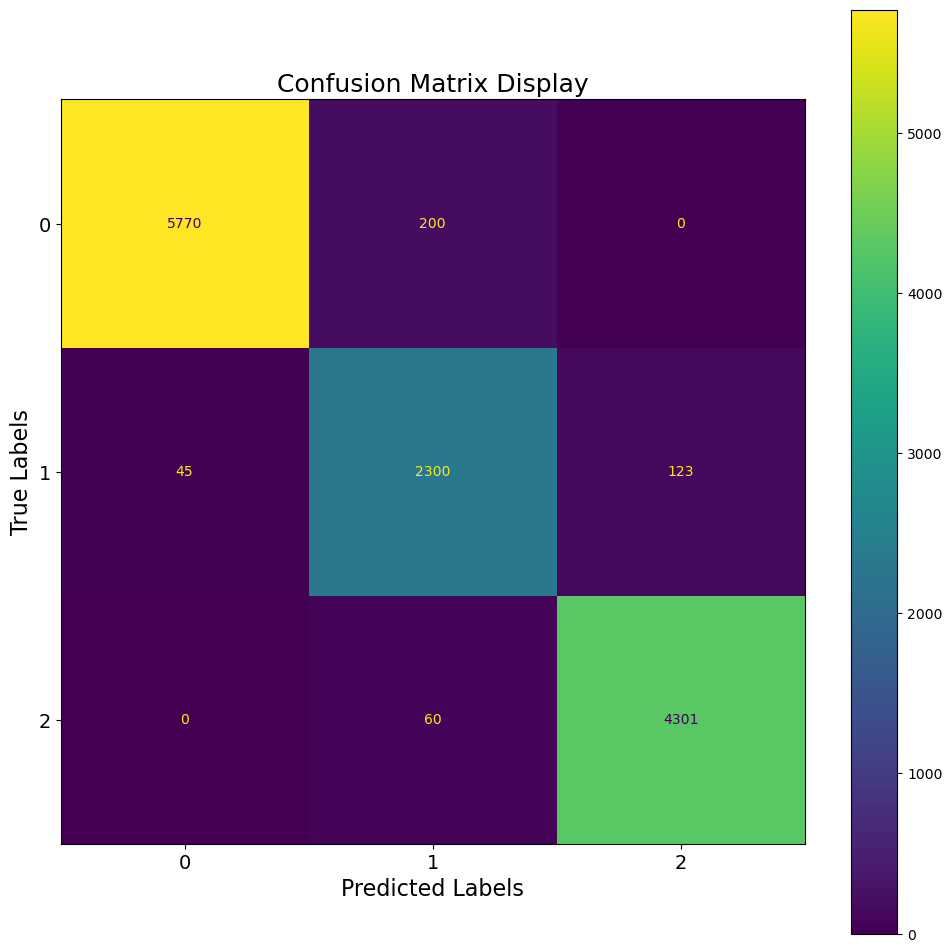

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
#CONFUSION MATRIX
# Assumi che 'model' sia il tuo modello e 'test_loader' sia il DataLoader per i tuoi dati di test
model.eval()  # Imposta il modello in modalità di valutazione
all_preds = []
all_labels = []

with torch.no_grad():  # Disattiva il calcolo del gradiente per l'inferenza
    for inputs, labels in data_loader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)



# Calcola la confusion matrix (cm) se non lo hai già fatto
# cm = confusion_matrix(all_labels, all_preds)

# Crea l'oggetto display per la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Personalizza la visualizzazione
fig, ax = plt.subplots(figsize=(12, 12))  # Aumenta la dimensione della figura per una visualizzazione più chiara
disp.plot(ax=ax, cmap='viridis')  # Scegli una colormap diversa per un aspetto migliore

# Personalizza ulteriormente
ax.set_title('Confusion Matrix Display', fontsize=18)  # Imposta un titolo con una dimensione del carattere maggiore
ax.set_xlabel('Predicted Labels', fontsize=16)  # Personalizza l'etichetta dell'asse X
ax.set_ylabel('True Labels', fontsize=16)  # Personalizza l'etichetta dell'asse Y
ax.tick_params(axis='both', which='major', labelsize=14)  # Aumenta la dimensione dei tick labels

# Mostra la griglia (opzionale)
ax.grid(False)  # Disattiva la griglia per una visualizzazione più pulita

# Mostra l'immagine
#plt.show()

plt.savefig(f'{pathname}/ConfusionMatrix.png')

